In [1]:
import shap
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
merged_path = "../data/plankton-patrol/Plankton Patrol/Data/plank_Chesapeake_buoywater_merged.csv"
data = pd.read_csv(merged_path)

In [3]:
# merge columns from two datasets - they do not overlap
data['Chlorophyll_Merged'] = data['Chlorophyll'].fillna(data['CHLA'])
data = data.drop(columns=['Chlorophyll','CHLA'])
data = data.rename(columns={'Chlorophyll_Merged': 'Chlorophyll'})

data['Salinity_Merged'] = data['Salinity'].fillna(data['SALINITY'])
data = data.drop(columns=['Salinity','SALINITY'])
data = data.rename(columns={'Salinity_Merged': 'Salinity'})

data['Wtemp_Merged'] = data['Temperature'].fillna(data['WTEMP'])
data = data.drop(columns=['Temperature','WTEMP'])
data = data.rename(columns={'Wtemp_Merged': 'Temperature'})

data['DO_Merged'] = data['Oxygen'].fillna(data['DO'])
data = data.drop(columns=['Oxygen','DO'])
data = data.rename(columns={'DO_Merged': 'Oxygen'})

In [4]:
data.columns

Index(['Air Temperature', 'Air pressure', 'Humidity', 'Wind speed',
       'Wind Direction', 'Turbidity', 'Significant wave height',
       'Wave from direction', 'Wave period', 'North surface currents',
       'East surface currents', 'Sample_year', 'Sample_month', 'Sample_day',
       'Sample_hour', 'Sample_minute', 'Sample_second', 'Latitude',
       'Longitude', 'TotalDepth', 'UpperPycnocline', 'LowerPycnocline',
       'Depth', 'DIN', 'DOC', 'DON', 'DOP', 'DO_SAT_P', 'FSS', 'KD', 'NH4F',
       'NO23F', 'NO2F', 'NO3F', 'PC', 'PH', 'PHEO', 'PN', 'PO4F', 'PP',
       'SECCHI', 'SIF', 'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP',
       'TSS', 'VSS', 'Chlorophyll', 'Salinity', 'Temperature', 'Oxygen'],
      dtype='object')

In [5]:
data = data.drop(columns=['Wind Direction','Wave from direction','Sample_minute','Sample_second'])

In [6]:
X, y = data.drop(['Chlorophyll'], axis=1), data['Chlorophyll']

In [7]:
# Define the parameter grid to search over
# model = xgboost.XGBRegressor(
#     max_depth=3,  # Maximum depth of a tree
#     learning_rate=0.1,  # Learning rate
#     n_estimators=100,  # Number of trees
#     subsample=0.8,  # Subsample ratio of the training instances
#     colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
#     gamma=0,  # Minimum loss reduction required to make a further partition
#     min_child_weight=1,  # Minimum sum of instance weight needed in a child
#     device="cuda",
#     enable_categorical=True,
# )
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "n_estimators": [50, 100, 200],
}
models = {
    "LightGBM": (
        lgb.LGBMRegressor(),
        {
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001]
        },
    ),
    "XGBoost": (
        xgb.XGBRegressor(),
        {
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001]
        },
    #,
    "MLPRegressor": (
        MLPRegressor(max_iter=1000),
        {"hidden_layer_sizes": [(50, 50), (100,)], "learning_rate_init": [0.001, 0.01]},
    ),
}

# models = {
#     'LightGBM': lgb.LGBMRegressor(),
#     'XGBoost': xgb.XGBRegressor(),
#     'MLPRegressor': CatBoostRegressor(silent=True)
# }
# Make custom scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mse_scores = []
kfold_bestparams = []
allshapvalues = []
best_models = {}
kf = KFold(n_splits=5)
for model_name, (model, param_grid) in models.items():


    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=kf, scoring=mse_scorer
    )

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42
    # )
    # Fit the grid search to the training data
    # grid_search.fit(X_train, y_train)
    grid_search.fit(X, y)

    # Get the best parameters
    # best_params = grid_search.best_params_
    # print(f"Best Parameters: {best_params}")

    # Create a new model with the best parameters
    # best_model = model(**best_params)
    # # Train the best model
    # best_model.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Store the best model and its parameters
    best_models[model_name] = {
        "best_estimator": best_model,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }
    # Predict on the test set
    # y_pred_best = best_model.predict(X_test)
    # mse = mean_squared_error(y_test, y_pred_best)

    # Evaluate the best model
    # accuracy_best = (y_pred_best == y_test).mean()
    
    print(f"MSE with Best Parameters: {best_models[model_name]['best_score']}")
    mse_scores.append(best_models[model_name]['best_score'])
    kfold_bestparams.append(best_models[model_name]['best_params'])

    # plt.figure()
    explainer = shap.Explainer(model=best_model, masker=X)
    # plt.savefig(
    # f"shap_explainer_best_{model_name}_fold-{i}.png", bbox_inches="tight"
    # )
    # plt.close()
    # for i, (train_index, test_index) in enumerate(kf.split(X)):
    #     X_train, X_test, y_train, y_test = (
    #         X.iloc[train_index],
    #         X.iloc[test_index],
    #         y.iloc[train_index],
    #         y.iloc[test_index],
    #     )
    shap_values = explainer(X)
    allshapvalues.append(shap_values)
    explainer.__class__

    # plt.figure()
    shap.summary_plot(shap_values, X, show=False)
    # plt.savefig(
    #     f"shap_summary_plot_best_{model_name}_fold-{i}.png", bbox_inches="tight"
    # )
    # plt.close()

MSE with Best Parameters: -159.9751888779485


  4%|=                   | 49217/1304147 [24:17<619:10]       

Season: winter
---------------------------------
MSE with Best Parameters: -67.70916095814614


100%|===================| 265119/265476 [05:36<00:00]        

None


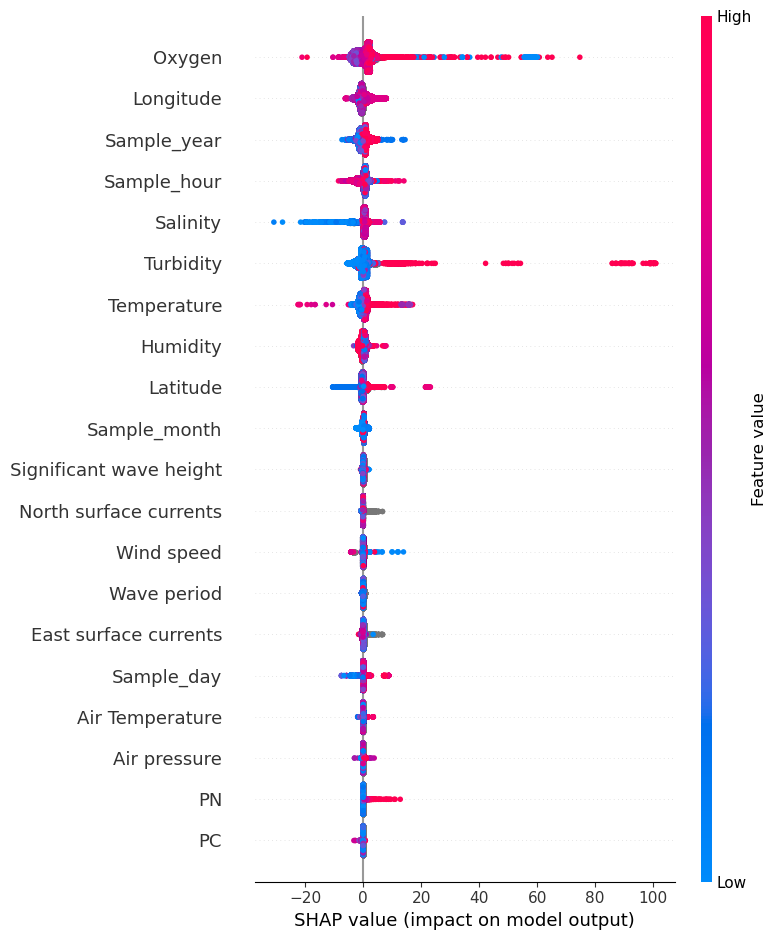

In [2]:
season = 'winter'
merged_path = '../data/plank_Chesapeake_buoywater_merged_'+ season + '.csv'
data = pd.read_csv(merged_path)

# merge columns from two datasets - they do not overlap
data['Chlorophyll_Merged'] = data['Chlorophyll'].fillna(data['CHLA'])
data = data.drop(columns=['Chlorophyll','CHLA'])
data = data.rename(columns={'Chlorophyll_Merged': 'Chlorophyll'})

data['Salinity_Merged'] = data['Salinity'].fillna(data['SALINITY'])
data = data.drop(columns=['Salinity','SALINITY'])
data = data.rename(columns={'Salinity_Merged': 'Salinity'})

data['Wtemp_Merged'] = data['Temperature'].fillna(data['WTEMP'])
data = data.drop(columns=['Temperature','WTEMP'])
data = data.rename(columns={'Wtemp_Merged': 'Temperature'})

data['DO_Merged'] = data['Oxygen'].fillna(data['DO'])
data = data.drop(columns=['Oxygen','DO'])
data = data.rename(columns={'DO_Merged': 'Oxygen'})

data = data.drop(columns=['Wind Direction','Wave from direction','Sample_minute','Sample_second'])

X, y = data.drop(['Chlorophyll'], axis=1), data['Chlorophyll']

print(f"Season: {season}")
print(f"---------------------------------")

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "n_estimators": [50, 100, 200],
}
models = {
    "XGBoost": (
        xgb.XGBRegressor(device="cuda"),
        {
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001]
        },
    )
}

# Make custom scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mse_scores = []
kfold_bestparams = []
allshapvalues = []
best_models = {}
kf = KFold(n_splits=5)
for model_name, (model, param_grid) in models.items():

    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=kf, scoring=mse_scorer
    )

    grid_search.fit(X, y)

    # Get the best parameters
    best_model = grid_search.best_estimator_

    # Store the best model and its parameters
    best_models[model_name] = {
        "best_estimator": best_model,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }
    
    print(f"MSE with Best Parameters: {best_models[model_name]['best_score']}")
    mse_scores.append(best_models[model_name]['best_score'])
    kfold_bestparams.append(best_models[model_name]['best_params'])

    explainer = shap.Explainer(model=best_model, masker=X)
    shap_values = explainer(X)
    allshapvalues.append(shap_values)
    explainer.__class__

    print(shap.summary_plot(shap_values, X, show=False))

Season: spring
---------------------------------
MSE with Best Parameters: -95.25781698844301


100%|===================| 346814/346908 [25:57<00:00]        

None


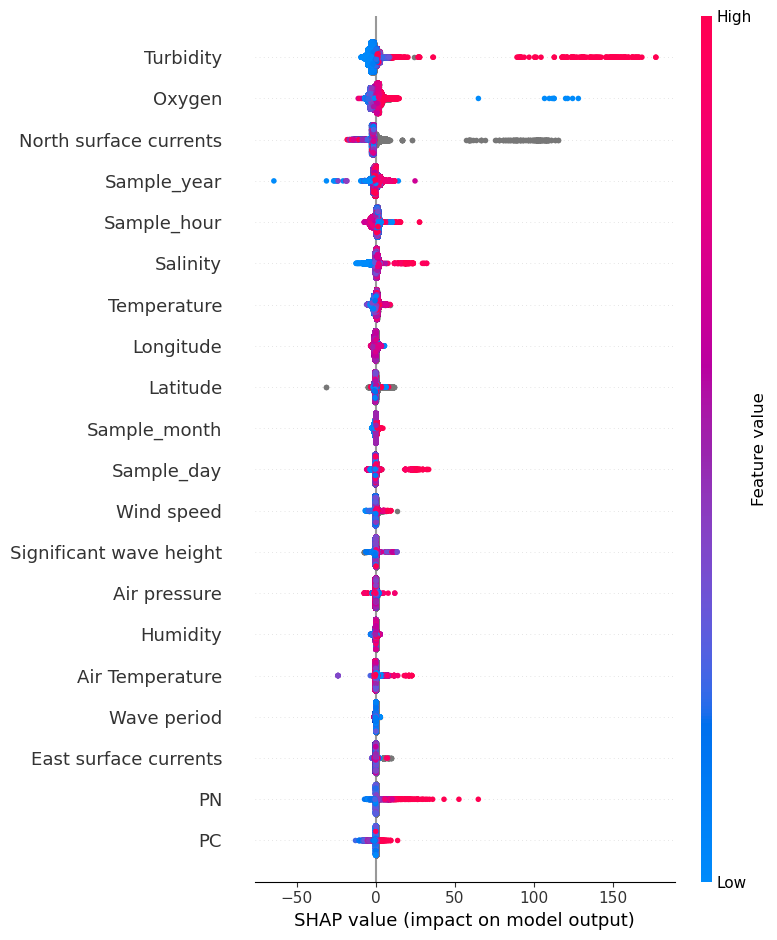

In [3]:
season = 'spring'
merged_path = '../data/plank_Chesapeake_buoywater_merged_'+ season + '.csv'
data = pd.read_csv(merged_path)

# merge columns from two datasets - they do not overlap
data['Chlorophyll_Merged'] = data['Chlorophyll'].fillna(data['CHLA'])
data = data.drop(columns=['Chlorophyll','CHLA'])
data = data.rename(columns={'Chlorophyll_Merged': 'Chlorophyll'})

data['Salinity_Merged'] = data['Salinity'].fillna(data['SALINITY'])
data = data.drop(columns=['Salinity','SALINITY'])
data = data.rename(columns={'Salinity_Merged': 'Salinity'})

data['Wtemp_Merged'] = data['Temperature'].fillna(data['WTEMP'])
data = data.drop(columns=['Temperature','WTEMP'])
data = data.rename(columns={'Wtemp_Merged': 'Temperature'})

data['DO_Merged'] = data['Oxygen'].fillna(data['DO'])
data = data.drop(columns=['Oxygen','DO'])
data = data.rename(columns={'DO_Merged': 'Oxygen'})

data = data.drop(columns=['Wind Direction','Wave from direction','Sample_minute','Sample_second'])

X, y = data.drop(['Chlorophyll'], axis=1), data['Chlorophyll']

print(f"Season: {season}")
print(f"---------------------------------")

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "n_estimators": [50, 100, 200],
}
models = {
    "XGBoost": (
        xgb.XGBRegressor(device="cuda"),
        {
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001]
        },
    )
}

# Make custom scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mse_scores = []
kfold_bestparams = []
allshapvalues = []
best_models = {}
kf = KFold(n_splits=5)
for model_name, (model, param_grid) in models.items():

    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=kf, scoring=mse_scorer
    )

    grid_search.fit(X, y)

    # Get the best parameters
    best_model = grid_search.best_estimator_

    # Store the best model and its parameters
    best_models[model_name] = {
        "best_estimator": best_model,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }
    
    print(f"MSE with Best Parameters: {best_models[model_name]['best_score']}")
    mse_scores.append(best_models[model_name]['best_score'])
    kfold_bestparams.append(best_models[model_name]['best_params'])

    explainer = shap.Explainer(model=best_model, masker=X)
    shap_values = explainer(X)
    allshapvalues.append(shap_values)
    explainer.__class__

    print(shap.summary_plot(shap_values, X, show=False))

Season: summer
---------------------------------
MSE with Best Parameters: -322.4904332447653


100%|===================| 359300/359337 [19:26<00:00]        

None


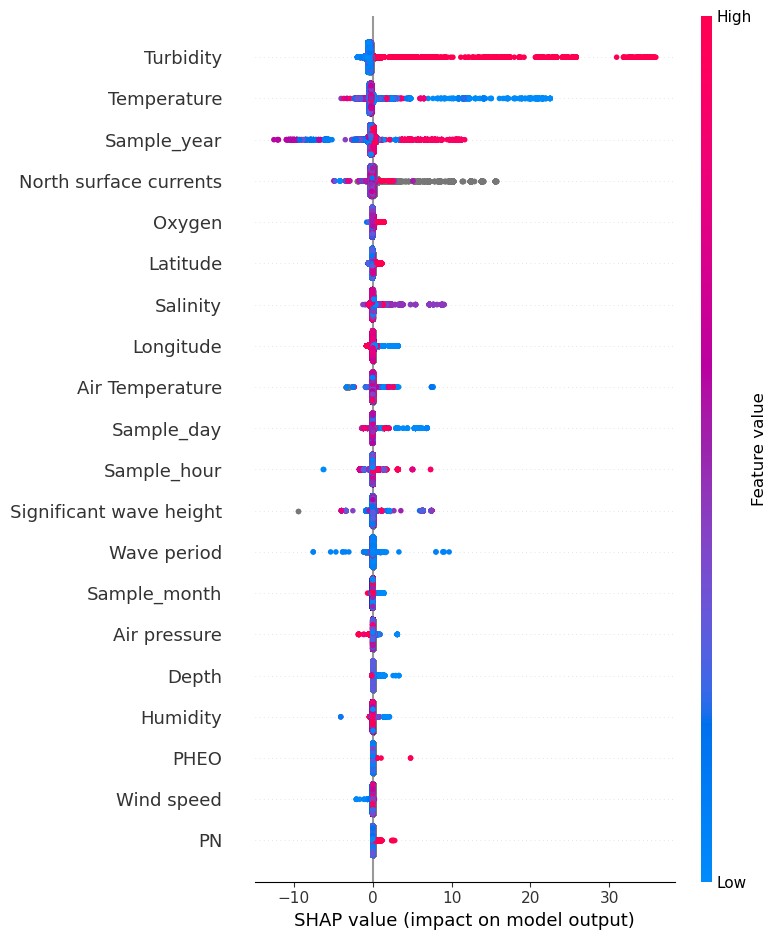

In [4]:
season = 'summer'
merged_path = '../data/plank_Chesapeake_buoywater_merged_'+ season + '.csv'
data = pd.read_csv(merged_path)

# merge columns from two datasets - they do not overlap
data['Chlorophyll_Merged'] = data['Chlorophyll'].fillna(data['CHLA'])
data = data.drop(columns=['Chlorophyll','CHLA'])
data = data.rename(columns={'Chlorophyll_Merged': 'Chlorophyll'})

data['Salinity_Merged'] = data['Salinity'].fillna(data['SALINITY'])
data = data.drop(columns=['Salinity','SALINITY'])
data = data.rename(columns={'Salinity_Merged': 'Salinity'})

data['Wtemp_Merged'] = data['Temperature'].fillna(data['WTEMP'])
data = data.drop(columns=['Temperature','WTEMP'])
data = data.rename(columns={'Wtemp_Merged': 'Temperature'})

data['DO_Merged'] = data['Oxygen'].fillna(data['DO'])
data = data.drop(columns=['Oxygen','DO'])
data = data.rename(columns={'DO_Merged': 'Oxygen'})

data = data.drop(columns=['Wind Direction','Wave from direction','Sample_minute','Sample_second'])

X, y = data.drop(['Chlorophyll'], axis=1), data['Chlorophyll']

print(f"Season: {season}")
print(f"---------------------------------")

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "n_estimators": [50, 100, 200],
}
models = {
    "XGBoost": (
        xgb.XGBRegressor(device="cuda"),
        {
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001]
        },
    )
}

# Make custom scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mse_scores = []
kfold_bestparams = []
allshapvalues = []
best_models = {}
kf = KFold(n_splits=5)
for model_name, (model, param_grid) in models.items():

    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=kf, scoring=mse_scorer
    )

    grid_search.fit(X, y)

    # Get the best parameters
    best_model = grid_search.best_estimator_

    # Store the best model and its parameters
    best_models[model_name] = {
        "best_estimator": best_model,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }
    
    print(f"MSE with Best Parameters: {best_models[model_name]['best_score']}")
    mse_scores.append(best_models[model_name]['best_score'])
    kfold_bestparams.append(best_models[model_name]['best_params'])

    explainer = shap.Explainer(model=best_model, masker=X)
    shap_values = explainer(X)
    allshapvalues.append(shap_values)
    explainer.__class__

    print(shap.summary_plot(shap_values, X, show=False))

Season: fall
---------------------------------
MSE with Best Parameters: -82.45119820130046


100%|===================| 331733/332426 [04:57<00:00]        

None


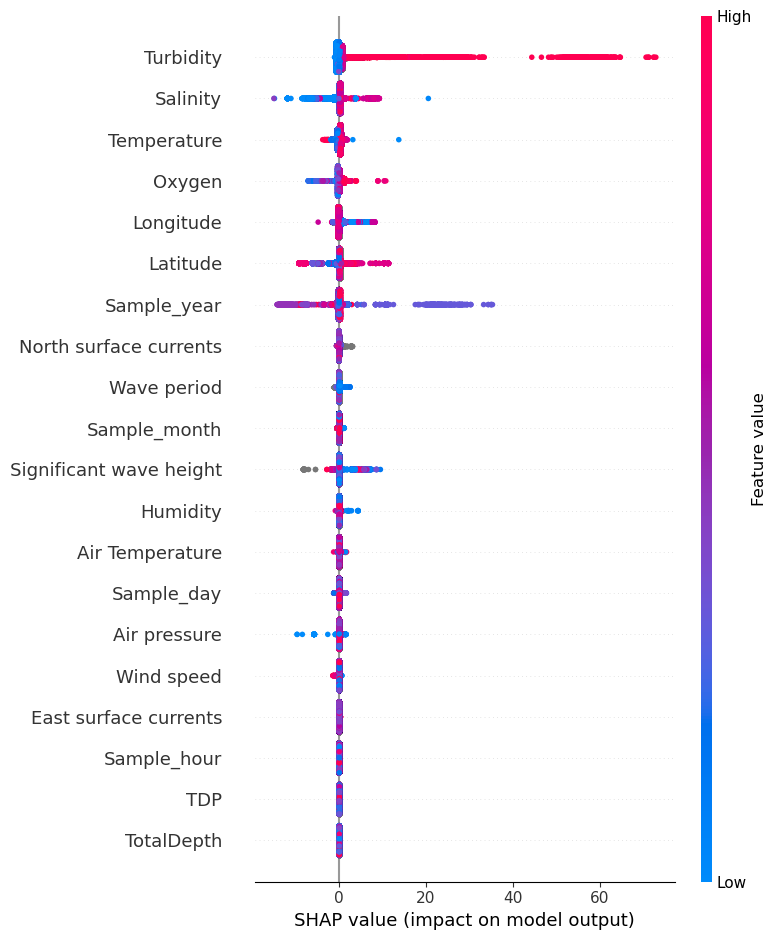

In [5]:
season = 'fall'
merged_path = '../data/plank_Chesapeake_buoywater_merged_'+ season + '.csv'
data = pd.read_csv(merged_path)

# merge columns from two datasets - they do not overlap
data['Chlorophyll_Merged'] = data['Chlorophyll'].fillna(data['CHLA'])
data = data.drop(columns=['Chlorophyll','CHLA'])
data = data.rename(columns={'Chlorophyll_Merged': 'Chlorophyll'})

data['Salinity_Merged'] = data['Salinity'].fillna(data['SALINITY'])
data = data.drop(columns=['Salinity','SALINITY'])
data = data.rename(columns={'Salinity_Merged': 'Salinity'})

data['Wtemp_Merged'] = data['Temperature'].fillna(data['WTEMP'])
data = data.drop(columns=['Temperature','WTEMP'])
data = data.rename(columns={'Wtemp_Merged': 'Temperature'})

data['DO_Merged'] = data['Oxygen'].fillna(data['DO'])
data = data.drop(columns=['Oxygen','DO'])
data = data.rename(columns={'DO_Merged': 'Oxygen'})

data = data.drop(columns=['Wind Direction','Wave from direction','Sample_minute','Sample_second'])

X, y = data.drop(['Chlorophyll'], axis=1), data['Chlorophyll']

print(f"Season: {season}")
print(f"---------------------------------")

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "n_estimators": [50, 100, 200],
}
models = {
    "XGBoost": (
        xgb.XGBRegressor(device="cuda"),
        {
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001]
        },
    )
}

# Make custom scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mse_scores = []
kfold_bestparams = []
allshapvalues = []
best_models = {}
kf = KFold(n_splits=5)
for model_name, (model, param_grid) in models.items():

    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=kf, scoring=mse_scorer
    )

    grid_search.fit(X, y)

    # Get the best parameters
    best_model = grid_search.best_estimator_

    # Store the best model and its parameters
    best_models[model_name] = {
        "best_estimator": best_model,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }
    
    print(f"MSE with Best Parameters: {best_models[model_name]['best_score']}")
    mse_scores.append(best_models[model_name]['best_score'])
    kfold_bestparams.append(best_models[model_name]['best_params'])

    explainer = shap.Explainer(model=best_model, masker=X)
    shap_values = explainer(X)
    allshapvalues.append(shap_values)
    explainer.__class__

    print(shap.summary_plot(shap_values, X, show=False))